In [1]:
import os
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F

import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torch.autograd import Variable

import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor, Compose, Resize, Normalize
from torchvision.io import read_image

In [2]:
device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
print(f"Using {device} device")

Using mps device


In [3]:
class ImageDataset(Dataset):
    def __init__(self,root_folder,transform):
        self.transform=transform
        self.img_folder=root_folder+'img/'

        self.image_names=[i for i in os.listdir(self.img_folder) if '.jpg' in i]
        self.attr = pd.read_csv(root_folder+'attr.csv').replace(-1,0)
        _ = self.attr.pop('image_id')
        
        self.num_feat = len(self.attr.columns)
        self.order = list(self.attr.columns)
        
        self.attr = self.attr.values
   
    def __len__(self):
        return len(self.image_names)
 
    def __getitem__(self, index):
        image_path = self.img_folder + self.image_names[index]
        image=Image.open(image_path)
        image=self.transform(image)
        label = torch.tensor(self.attr[index], dtype = torch.float)

        return image, label

In [4]:
img_dim = 32
batch_size = 16
transform = Compose([Resize((img_dim, img_dim)),
                     ToTensor(),
                     Normalize(0,1)])

training_data = ImageDataset(root_folder='sample_data/',transform=transform)
train_dataloader = DataLoader(training_data, batch_size = batch_size)

In [5]:
training_data.num_feat

40

In [6]:
for X, y in train_dataloader:
    print(X.shape, y.shape)
    break

torch.Size([16, 3, 32, 32]) torch.Size([16, 40])


In [7]:
def weights_init(m):
    classname = m.__class__.__name__

    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)
    elif classname.find('Linear') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
        if m.bias is not None:
            m.bias.data.fill_(0)

In [8]:
class Encoder(nn.Module):
    def __init__(self, z_dim):
        super(Encoder, self).__init__()
        self.z_dim = z_dim
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, 5, stride = 1,bias=False),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(negative_slope = 0.1),
            
            nn.Conv2d(32, 64, 4, stride = 2,bias=False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(negative_slope = 0.1),
            
            nn.Conv2d(64, 128, 4, stride = 2,bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(negative_slope = 0.1),
            
            nn.Conv2d(128, 256, 4, stride = 1,bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(negative_slope = 0.1),
            
            nn.Conv2d(256, 2*z_dim, 2, stride = 1, bias=True)
        )
    def reparameterize(self, z):
        z = z.view(z.size(0), -1)
        mu, log_sigma = z[:, :self.z_dim], z[:, self.z_dim:]
        std = torch.exp(log_sigma)
        eps = torch.randn_like(std)
        return mu + eps*std
        
    def forward(self, x):
        z = self.encoder(x)
        z = self.reparameterize(z)
        return z.view(x.size(0), self.z_dim)

In [9]:
class Discriminator(nn.Module):
    def __init__(self, num_channel = 3):
        super(Discriminator, self).__init__()
        
        self.conv1x = nn.Conv2d(num_channel, 32, 5, stride = 1, bias=False)
        self.conv2x = nn.Conv2d(32, 64, 4, stride = 2, bias=False)
        self.bn1x = nn.BatchNorm2d(64)
        self.conv3x = nn.Conv2d(64, 128, 4, 2, 1, bias=False)
        self.bn2x =  nn.BatchNorm2d(128)
        self.conv4x = nn.Conv2d(128, 256, 4, 2, 1, bias=False)
        self.bn3x = nn.BatchNorm2d(256)
        self.conv5x = nn.Conv2d(256, 512, 4, 2, 1, bias=False)
        self.bn4x = nn.BatchNorm2d(512)
        
        self.conv1z = nn.Conv2d(z_dim, 512, 1, stride = 1, bias=False)
        self.conv2z = nn.Conv2d(512, 512, 1, stride = 1, bias=False)
        
        self.conv1xz = nn.Conv2d(1024, 1024, 1, stride = 1, bias=False)
        self.conv2xz = nn.Conv2d(1024, 1024, 1, stride = 1, bias=False)
        self.conv3xz = nn.Conv2d(1024, 1, 1, stride = 1, bias=False)
       
    def forward(self, x, z):
        x = F.leaky_relu(self.conv1x(x), negative_slope = 0.2)
        x = F.leaky_relu(self.bn1x(self.conv2x(x)), negative_slope = 0.2)
        x = F.leaky_relu(self.bn2x(self.conv3x(x)), negative_slope = 0.2)
        x = F.leaky_relu(self.bn3x(self.conv4x(x)), negative_slope = 0.2)
        x = F.leaky_relu(self.bn4x(self.conv5x(x)), negative_slope = 0.2)
       
        z = F.leaky_relu(self.conv1z(z), negative_slope = 0.2)
        z = F.leaky_relu(self.conv2z(z), negative_slope = 0.2)
    
        xz = torch.cat((x,z), dim = 1)
        
        xz = F.leaky_relu(self.conv1xz(xz), negative_slope = 0.2)
        xz = F.leaky_relu(self.conv2xz(xz), negative_slope = 0.2)
        xz = F.leaky_relu(self.conv3xz(xz), negative_slope = 0.2)
        
        return xz

In [10]:
class PriorLatent(nn.Module):
    def __init__(self, in_feat, out_feat):
        super(PriorLatent, self).__init__()
        self.linear = nn.Linear(in_feat, out_feat)
        
    def forward(self, eps):
        return self.linear(eps)

In [11]:
class Generator(nn.Module):
    def __init__(self, z_dim, img_dim, split = None, feat_num = None, num_channel = 3):
        super(Generator, self).__init__()
        self.split = split
        if self.split is None:
            self.split = z_dim//2
        self.output_bias = nn.Parameter(torch.zeros(3,img_dim, img_dim), requires_grad = True)
        self.prior = PriorLatent(self.split, feat_num)
        
        self.main = nn.Sequential(
            nn.ConvTranspose2d(90, 256, 4, stride = 1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(negative_slope = 0.1, inplace=True),
            
            nn.ConvTranspose2d(256, 128, 4, stride = 2, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(negative_slope = 0.1, inplace=True),
            
            nn.ConvTranspose2d(128, 64, 4, stride = 1, bias=False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(negative_slope = 0.1, inplace=True),
            
            nn.ConvTranspose2d(64, 32, 4, stride = 2, bias=False),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(negative_slope = 0.1, inplace=True),
            
            nn.ConvTranspose2d(32, 32, 5, stride = 1, bias=False),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(negative_slope = 0.1, inplace=True),
            
            nn.ConvTranspose2d(32, 3, 1, stride = 1, bias=True),
            nn.Sigmoid()
        )
    
    def forward(self, z):
        eps, z_ = torch.split(z, split_size_or_sections = self.split, dim = 1)
        eps = eps.view(z.shape[0], eps.shape[1])
        z_trans = self.prior(eps).view(z.shape[0], -1)
        
        z = torch.cat([z_trans, z_], dim = 1)
        z = z.view(z.shape[0],-1,1,1)
        z = self.main(z)
        out = z + self.output_bias
        
        return out, z_trans
    
    def get_prior(self, epsilon):
        return self.prior(epsilon) 
    
    def forward_intervened(self, latent, z):
        z = torch.cat([latent, z_], dim = 1)
        z = z.view(z.shape[0],-1,1,1)
        z = self.main(z)
        out = z + self.output_bias
        
        return out, latent

In [12]:
z_dim = 100

g = Generator(z_dim, img_dim, split = 50, feat_num = 40).to(device)
e = Encoder(z_dim).to(device)
d = Discriminator().to(device)

g.apply(weights_init)
e.apply(weights_init)
d.apply(weights_init)

Discriminator(
  (conv1x): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1), bias=False)
  (conv2x): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), bias=False)
  (bn1x): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3x): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn2x): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4x): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn3x): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5x): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn4x): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv1z): Conv2d(100, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (conv2z): Conv2d(512, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (conv1xz): Conv2d(1024, 1024, kernel_size=(1, 

In [13]:
criterion = nn.CrossEntropyLoss()

real_label = 1
fake_label = 0

lr = 1e-4
beta1 = 0.5

ge_param = list(g.parameters())+list(e.parameters())

opt_ge = optim.Adam(ge_param, lr = lr,  betas=(beta1, 0.999))
opt_d = optim.Adam(d.parameters(), lr = lr,  betas=(beta1, 0.999))

In [14]:
def plot_img(fake):
    with torch.no_grad():
        fake = np.transpose(fake.cpu().numpy(), (0, 2, 3, 1))

    _,ax = plt.subplots(1, 10, figsize=(24,4))
    for i in range(10):
        ax[i].imshow(fake[i])
    plt.show()

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/633 [00:00<?, ?it/s]

[1/20] D Loss : 167.44686 GE Loss : 175.21145


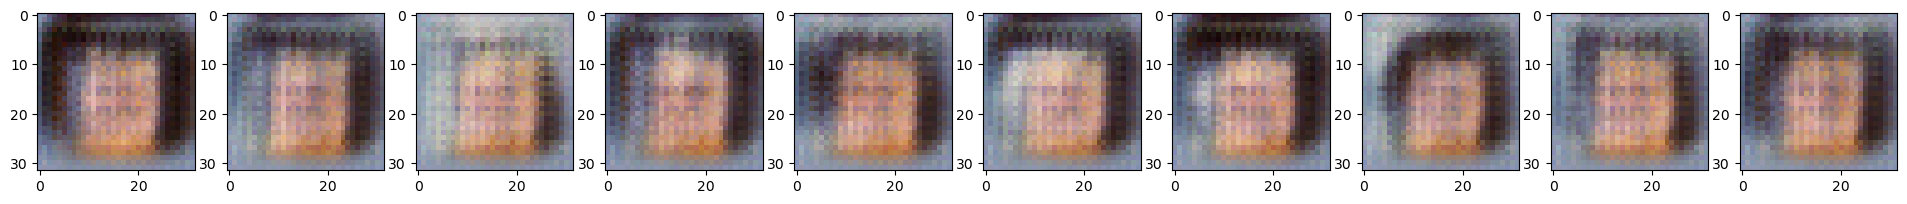

  0%|          | 0/633 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[2/20] D Loss : 166.13575 GE Loss : 169.67271


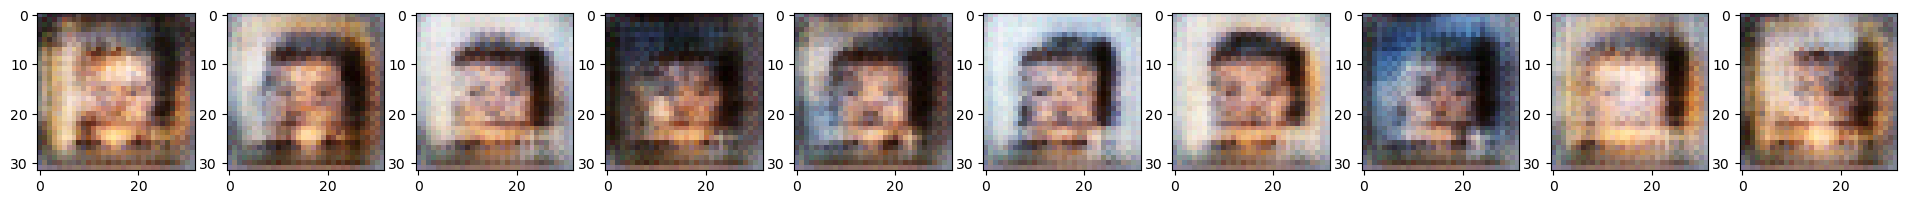

  0%|          | 0/633 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[3/20] D Loss : 164.84690 GE Loss : 166.14215


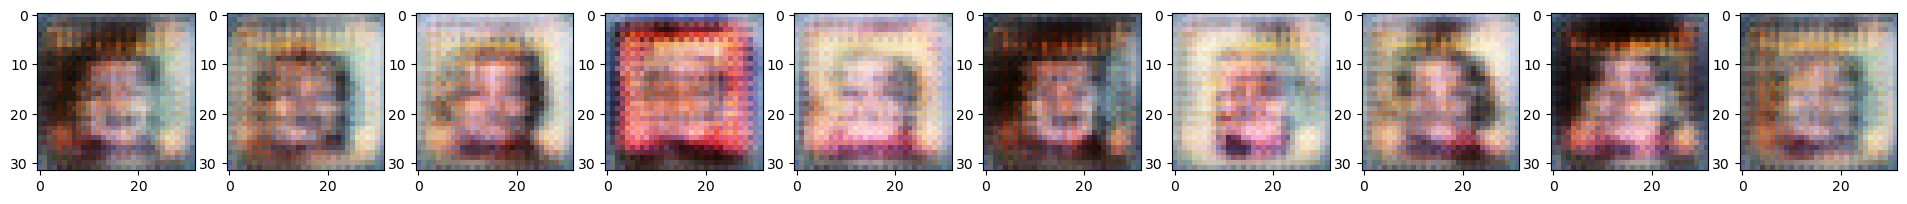

  0%|          | 0/633 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[4/20] D Loss : 163.38000 GE Loss : 165.14020


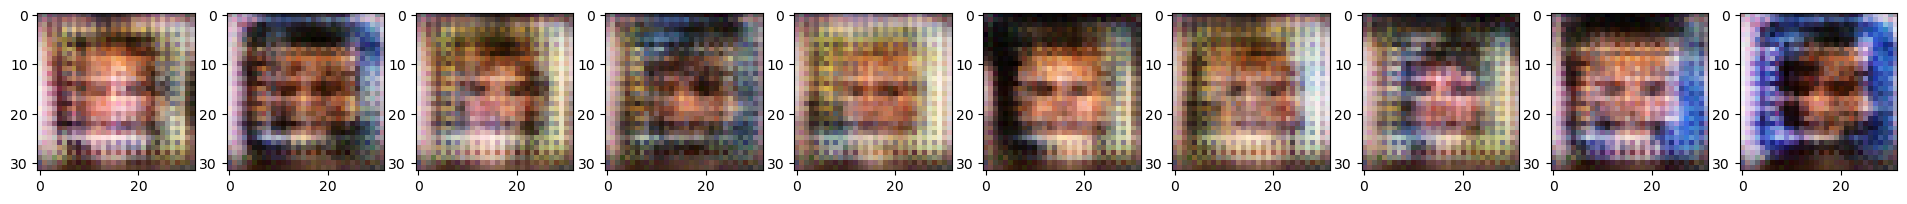

  0%|          | 0/633 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[5/20] D Loss : 162.22543 GE Loss : 163.41875


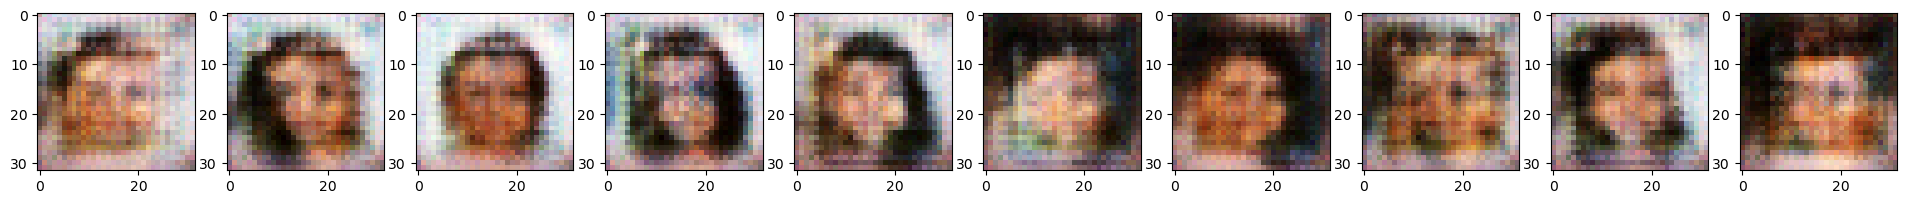

  0%|          | 0/633 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

[6/20] D Loss : 161.14226 GE Loss : 162.05251


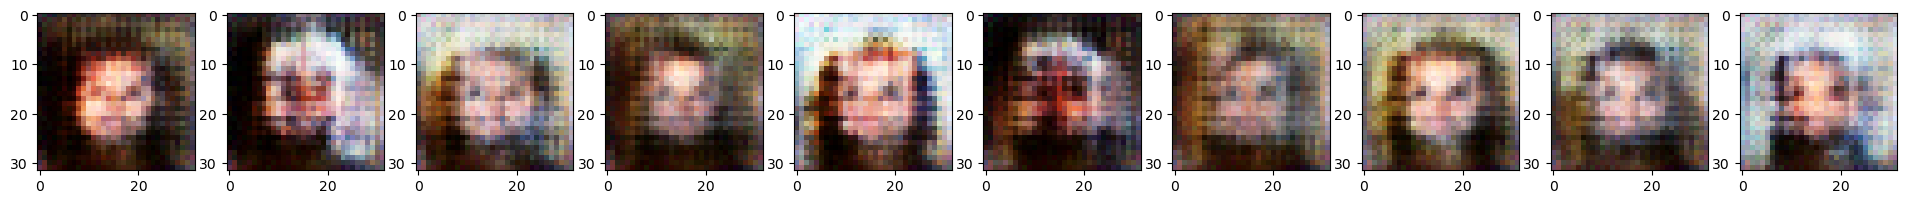

  0%|          | 0/633 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

[7/20] D Loss : 160.07651 GE Loss : 161.20809


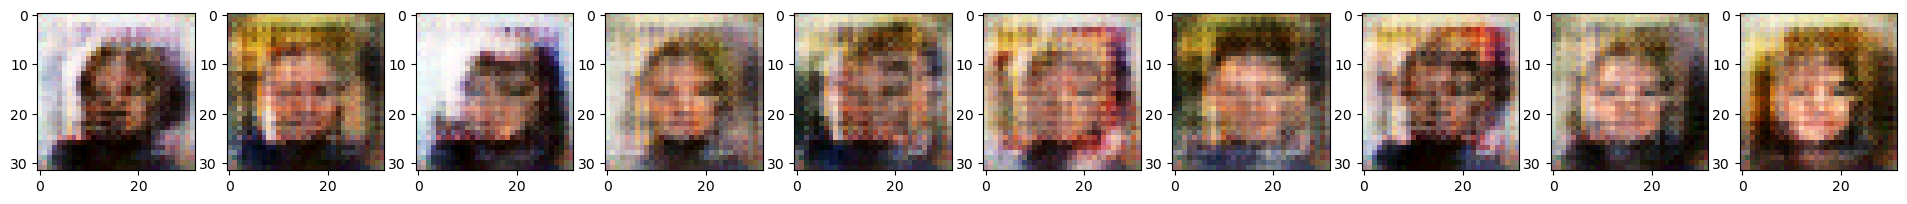

  0%|          | 0/633 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

[8/20] D Loss : 159.18632 GE Loss : 160.20430


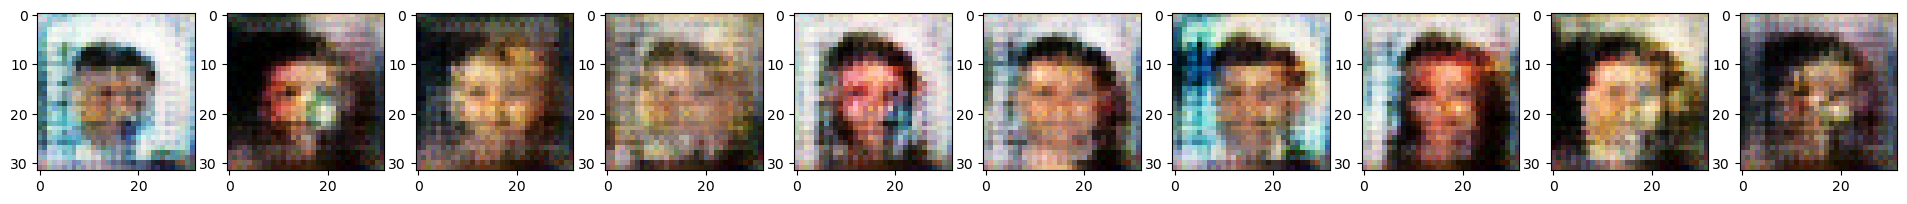

  0%|          | 0/633 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

[9/20] D Loss : 158.34566 GE Loss : 159.49504


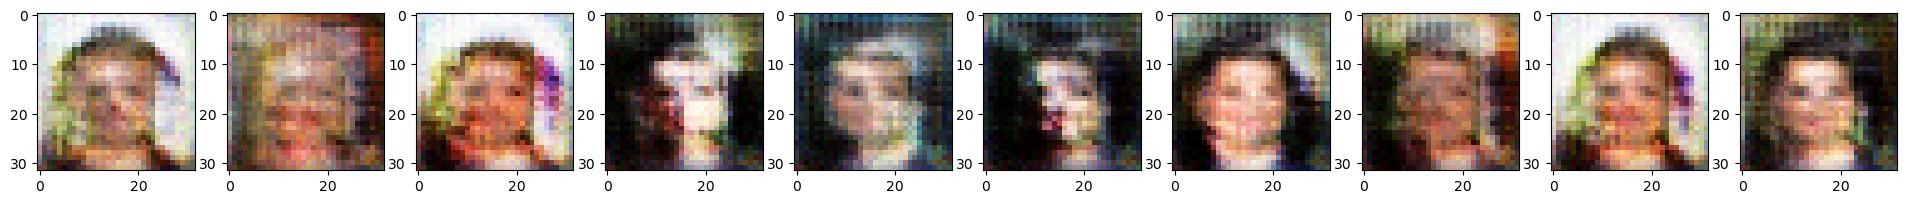

  0%|          | 0/633 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

[10/20] D Loss : 157.58882 GE Loss : 158.92083


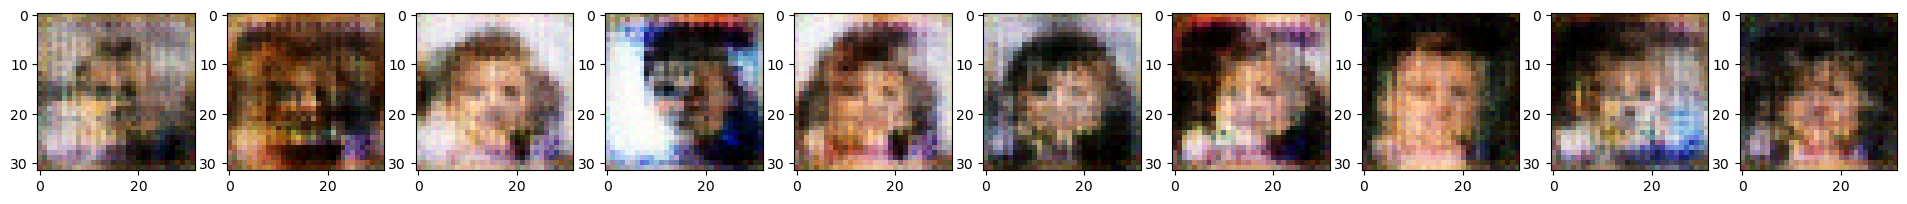

  0%|          | 0/633 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

[11/20] D Loss : 156.93854 GE Loss : 158.29422


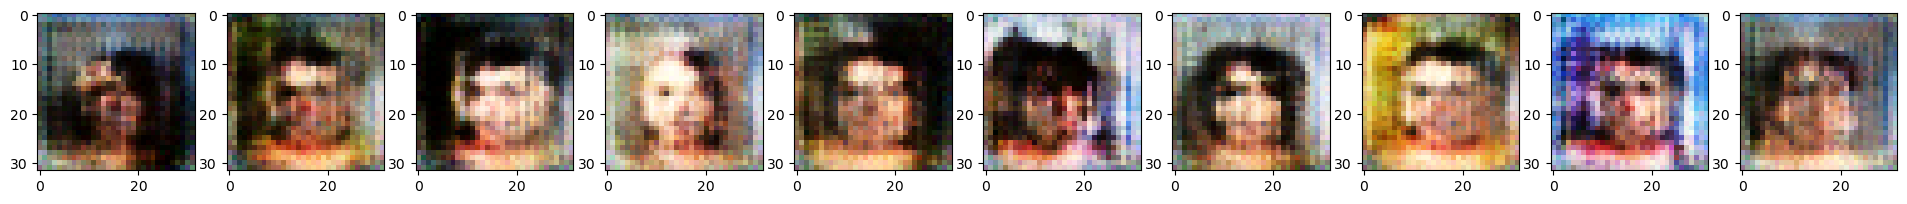

  0%|          | 0/633 [00:00<?, ?it/s]

In [ ]:
lambda_ = 5 

epochs = 20
num_steps = len(train_dataloader.dataset)//batch_size

clip_value = 1.2

for epoch in tqdm(range(epochs)):
    ge_loss, d_loss = 0, 0
    for step, (X, label) in tqdm(enumerate(train_dataloader), total=num_steps):
        X = X.to(device)
        label = label.to(device)

        y_true = Variable(torch.ones(X.size(0),1, dtype=torch.float).to(device), requires_grad = False)
        y_fake = Variable(torch.zeros(X.size(0), 1, dtype=torch.float).to(device), requires_grad = False)
        
        noise1 = Variable(torch.Tensor(X.size()).normal_(0, 0.1 * (epochs - epoch) / epochs),requires_grad=False).to(device)
        noise2 = Variable(torch.Tensor(X.size()).normal_(0, 0.1 * (epochs - epoch) / epochs),requires_grad=False).to(device)
   
        ######## TRAINING DISCRIMINATOR ###########
        opt_d.zero_grad()

        z_fake = Variable(torch.randn((X.size(0), z_dim)).to(device), requires_grad = False)
        x_fake, latent = g(z_fake)

        z_true = e(X).view(x_fake.shape[0], -1, 1, 1)
        z_fake = z_fake.view(x_fake.shape[0], -1, 1, 1)

        out_true = d(X+noise1, z_true).view(X.shape[0],-1)
        out_fake = d(x_fake+noise2, z_fake).view(X.shape[0],-1)

        loss_d = torch.mean(F.softplus(-out_true)) + torch.mean(F.softplus(out_fake)) + lambda_*criterion(latent, label)
        loss_d.backward()
        nn.utils.clip_grad_value_(d.parameters(), clip_value)
        opt_d.step()
            
        ######## TRAINING GENERATOR AND ENCODER PART ###########
            
        opt_ge.zero_grad()
            
        z_fake = Variable(torch.randn((X.size(0), z_dim)).to(device), requires_grad = False)
        x_fake, latent = g(z_fake)

        z_true = e(X).view(x_fake.shape[0], -1, 1, 1)
        z_fake = z_fake.view(x_fake.shape[0], -1, 1, 1)

        out_true = d(X+noise1, z_true).view(X.shape[0],-1)
        out_fake = d(x_fake+noise2, z_fake).view(X.shape[0],-1)
            
        loss_ge = torch.mean(F.softplus(out_true)) + torch.mean(F.softplus(-out_fake))+ lambda_*criterion(latent, label)
        loss_ge.backward()
        nn.utils.clip_grad_value_(ge_param, clip_value)
        opt_ge.step()
            
        ge_loss += loss_ge.item()
        d_loss += loss_d.item()
            
    print(f"[{epoch+1}/{epochs}] D Loss : {d_loss/num_steps:>.5f} GE Loss : {ge_loss/num_steps:>.5f}")
    if epoch % 1 == 0:
        z_fake = torch.randn((batch_size, z_dim)).to(device)
        out = g(z_fake)[0]
        plot_img(out) 

In [ ]:
z_fake = torch.randn((batch_size, z_dim)).to(device)
out = g(z_fake)[0]
plot_img(out)

In [ ]:
for X, y in train_dataloader:
    plot_img(X)
    plot_img(g(e(X.to(device)))[0])
    break

In [ ]:
for X, y in train_dataloader:
    print(y[0])
    print(g.prior(torch.split(e(X.to(device))[0], 50)[0]))
    break